In [1]:
import dask.array as da
import dask.dataframe as dd
import glob
import gzip
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import seaborn as sns
import shutil
from dask.distributed import Client
from dask_ml.model_selection import IncrementalSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from time import sleep

In [2]:
def download_nyc_taxi_data(year, month, output_dir, tag):
    """Funkcja pobierająca dane ze zbioru kursów nowojorskich taskówek dla określonego roku, miesiąca i rodzaju taksówki"""
    base_url = f'https://github.com/DataTalksClub/nyc-tlc-data/releases/download/{tag}/'
    file_name = f'{tag}_tripdata_{year}-{month:02d}.csv.gz'
    url = base_url + file_name
    
    output_path = os.path.join(output_dir, file_name)
    if os.path.exists(output_path):  # warunek sprawdzający, czy nie mamy już danego pliku, aby uniknąć zbędnego pobierania
        print(f'File already exists: {output_path}')
        return output_path

    for attempt in range(5):  # 5 prób pobierania w razie jakby zerwało na chwilę połączenie
        try:
            response = requests.get(url, stream=True, timeout=10)  # request GET o wskazany plik
            if response.status_code == 200:  # jeśli udało się pobrać plik zapisujemy go
                os.makedirs(output_dir, exist_ok=True)
                output_path = os.path.join(output_dir, file_name)
                with open(output_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=1024):
                        f.write(chunk)
                print(f'Downloaded: {file_name}')
                return output_path
            else:  # wyłapywanie błędów HTTP serwera
                print(f'Failed to download: {file_name}')
                return None
        except requests.exceptions.RequestException as e:  # wyłapywanie zerwanego połączenia
            print(f'Connection Error: {e}. Attempt {attempt + 1}.')
            sleep(2 ** attempt)  # oczekiwanie na nową próbę pobierania w różnych interwałach, żeby serwer nie uznał nas za bota

In [3]:
def extract_gz(input_path):
    """Funkcja rozpakowująca plik GZip"""
    output_path = input_path.replace('.gz', '')
    with gzip.open(input_path, 'rb') as f_in:
        with open(output_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f'Extracted: {output_path}')
    return output_path

In [4]:
def csv_to_parquet(input_csv, output_dir, npartitions=4):
    """Funkcja konwertująca pliki CSV na Parquet, zakładając tylko tagi datasetów green i yellow (pozostałe mocno odbiegają strukturą danych)"""
    os.makedirs(output_dir, exist_ok=True)

    dtypes = {  # optymalna definicja typów kolumn
        'VendorID': 'float32',
        'passenger_count': 'float32',
        'trip_distance': 'float32',
        'RatecodeID': 'float32',
        'store_and_fwd_flag': 'str',
        'PULocationID': 'float32',
        'DOLocationID': 'float32',
        'payment_type': 'float32',
        'fare_amount': 'float32',
        'extra': 'float32',
        'mta_tax': 'float32',
        'tip_amount': 'float32',
        'tolls_amount': 'float32',
        'improvement_surcharge': 'float32',
        'total_amount': 'float32',
        'congestion_surcharge': 'float32',
    }
    
    if 'green' in os.path.basename(input_csv).lower():  # przygotowanie kolumn do parsowania na typ datetime, z ujednoliceniem nazwy, bo jest rozbieżna pomiędzy green a yellow
        date_columns = ['lpep_pickup_datetime', 'lpep_dropoff_datetime']

        column_mapping = {
            'lpep_pickup_datetime': 'tpep_pickup_datetime',
            'lpep_dropoff_datetime': 'tpep_dropoff_datetime',
        }
    else:
        date_columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
        column_mapping = {}

    ddf = dd.read_csv(  # wczytanie danych do Dask Dataframe
        input_csv,
        dtype=dtypes,
        assume_missing=True,
        parse_dates=date_columns
    )

    if column_mapping:
        ddf = ddf.rename(columns=column_mapping)  # zastosowanie mapowania kolumn
        ddf = ddf.drop(columns=['ehail_fee', 'trip_type'], errors='ignore')  # usunięcie zbędnych kolumn

    ddf = ddf.repartition(npartitions=npartitions)  # podzielenie danych na określoną liczbę partycji
    output_path = os.path.join(output_dir, os.path.basename(input_csv).replace('.csv', ''))
    ddf.to_parquet(output_path, engine='pyarrow', write_index=False)  # zapisanie danych z DD do plików Parquet
    print(f'Converted to Parquet: {output_path}')
    return output_path

In [5]:
def exploratory_analysis_and_preprocessing(parquet_dir, cleaned_dir):
    """Funkcja wczytująca dane z plików Parquet do przeprowadzenia analizy eksploracyjnej i czyszczenia danych"""
    parquet_files = glob.glob(os.path.join(parquet_dir, '**', '*.parquet'), recursive=True)
    ddf = dd.read_parquet(parquet_files, engine='pyarrow')  # wczytanie danych z plików Parquet do Dask Dataframe

    print('Dataset head:\n', ddf.head())  # wyświetlenie kilku początkowych rekordów
    print('Dataset info:\n', ddf.info())  # wyświetlenie podstawowych informacji o datasecie
    print('Column types:')  # wyświetlenie typów kolumn
    for col in ddf.columns:
        print(f'{col}: {ddf[col].dtype}')

    missing_values = ddf.isnull().sum().compute()
    print('Missing values:\n', missing_values)  # wyświetlenie ilości brakujących wartości dla każdej kolumny

    ddf_cleaned = ddf.dropna()  # usunięcie rekordów z brakującymi wartościami
    unique_classes = ddf_cleaned['payment_type'].value_counts().compute()  # zliczenie ilości rekordów dla każdej klasy payment_type
    valid_payment_types = [int(cls) for cls in unique_classes.index]  # stworzenie listy unikalnych klas payment_type
    ddf_cleaned = ddf_cleaned[ddf_cleaned['payment_type'].isin(valid_payment_types)]  # wyfiltrowanie rekordów zawierających niepoprawne payment_type (NaN)

    os.makedirs(cleaned_dir, exist_ok=True)
    ddf_cleaned.to_parquet(cleaned_dir, engine='pyarrow', write_index=False)  # zapisanie oczyszczonych danych do nowych plików Parquet
    print(f'Cleaned data saved to: {cleaned_dir}')

In [6]:
def train_ml_model(cleaned_dir, model_dir):
    """Funkcja trenująca model uczenia maszynowego z dobieraniem odpowiednich hiperparametów"""
    parquet_files = glob.glob(os.path.join(cleaned_dir, '**', '*.parquet'), recursive=True)
    ddf = dd.read_parquet(parquet_files, engine='pyarrow')  # wczytanie danych z plików Parquet do Dask Dataframe

    chunk_size = 100000  # określenie odpowiedniej wielkości partycji
    X = ddf[['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount']].to_dask_array(lengths=True).rechunk((chunk_size, 4))  # określenie zmiennych niezależnych i zmiana układu danych na partycje o stałym rozmiarze (chunk_size x ilość zmiennych)
    y = ddf['payment_type'].to_dask_array(lengths=True).rechunk(chunk_size)  # określenie zmiennej zależnej (później przewidywanej)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # podział danych na zbiór treningowy i testowy

    model = SGDClassifier(loss='log_loss', tol=1e-3)  # inicjalizacja modelu SGDClassifier z logarytmiczną funkcją straty
    classes = da.unique(y_train).compute()  # pobranie ilości unikalnych klas w payment_type
    params = {  # określenie zakresów, z których będą dobierane parametry do modelu
        'alpha': np.logspace(-4, 1, num=1000),  # regularyzacja
        'l1_ratio': np.linspace(0, 1, num=1000),  # współczynnik regularyzacji
        'average': [True, False],  # czy uśredniać wyniki
        'penalty': ['l1', 'l2', 'elasticnet'],  # funkcja regresji
    }

    search = IncrementalSearchCV(  # inicjalizacja rozproszonego wyszukiwania optymalnych parametrów z biblioteki dask_ml
        model,
        params,
        random_state=0,  # określenie seedu (niekonieczne)
        n_initial_parameters=1000,  # liczba początkowych zestawów parametrów
        patience=20,  # maksymalna liczba iteracji bez poprawy
        max_iter=1000,  # maksymalna ogólna liczba iteracji
        decay_rate=None,  # szybkość zmniejszania wsparcia parametrów
    )
    search.fit(X, y, classes=classes)  # dopasowywanie modelu do danych
    
    print(f'Best Parameters: {search.best_params_}')  # wyświetlenie najlepszej znalezionej kombinacji parametrów
    best_model = search.best_estimator_  # przypisanie najlepszego modelu do zmiennej
    accuracy = best_model.score(X_test, y_test)  # obliczenie dokładności na zbiorze testowym
    print(f'Model accuracy: {accuracy}')  # wyświetlenie dokładności modelu
    
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f'model_{accuracy}.pkl')
    joblib.dump(best_model, model_path)  # zapisanie najlepszego modelu do pliku
    print(f'Model saved to: {model_path}')

    return model_path, X_test, y_test

In [7]:
def evaluate_model(model_path, X_test, y_test):
    """Funkcja oceniająca zapisany model"""
    model = joblib.load(model_path)  # wczytanie modelu z pliku
    y_pred = model.predict(X_test)  # generowanie predykcji klas payment_type
    unique_classes = sorted(da.unique(y_test).compute())  # pobranie ilości unikalnych klas w payment_type
    target_names = [f'Type {int(cls)}' for cls in unique_classes]  # wygenerowanie etykiet klas

    report = classification_report(y_test.compute(), y_pred, target_names=target_names)  # utworzenie raportu klasyfikacji
    print('Classification Report:\n', report)

    cm = confusion_matrix(y_test.compute(), y_pred)  # utworzenie macierzy pomyłek
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalizacji macierzy pomyłek, aby łatwiej widzieć proporcje liczb
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=target_names, yticklabels=target_names)  # utworzenie mapy cieplnej z macierzy pomyłek
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Normalised)')
    plt.show()

In [8]:
output_dir = './data'  # ścieżka do katalogu z danymi
parquet_dir = os.path.join(output_dir, 'parquet')  # ścieżka na pliki Parquet
cleaned_dir = os.path.join(parquet_dir, 'cleaned')  # ścieżka na oczyszczone pliki Parquet
model_dir = os.path.join(cleaned_dir, 'model')  # ścieżka na zapisywane modele

In [9]:
client = Client(n_workers=12, threads_per_worker=2, memory_limit='24GB')  # inicjalizacja klienta Dask
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 24,Total memory: 268.22 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54390,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 268.22 GiB
Comm: tcp://127.0.0.1:54444,Total threads: 2
Dashboard: http://127.0.0.1:54457/status,Memory: 22.35 GiB
Nanny: tcp://127.0.0.1:54393,


In [10]:
tags = ['yellow', 'green']  # określenie rodzajów taksówek, dla których pobieramy dane (yellow, green lub obydwa)
years = [2019, 2020, 2021]  # określenie, dla jakich lat pobieramy dane (2019-2021)
months = [i + 1 for i in range(12)]  # określenie miesięcy, dla których pobieramy dane

for tag in tags:  # główna pętla pobierająca i rozpakowująca pliki w zakresie wyżej zdefiniowanym
    for year in years:
        for month in months:
            gz_path = download_nyc_taxi_data(year, month, output_dir, tag)
            if gz_path:
                extract_gz(gz_path)
            if year == 2021 and month == 7:  # zatrzymanie pobierania, bo dane istnieją do 7 miesiąca 2021 roku 
                break

Downloaded: yellow_tripdata_2019-01.csv.gz
Extracted: ./data\yellow_tripdata_2019-01.csv
Downloaded: yellow_tripdata_2019-02.csv.gz
Extracted: ./data\yellow_tripdata_2019-02.csv
Downloaded: yellow_tripdata_2019-03.csv.gz
Extracted: ./data\yellow_tripdata_2019-03.csv
Downloaded: yellow_tripdata_2019-04.csv.gz
Extracted: ./data\yellow_tripdata_2019-04.csv
Downloaded: yellow_tripdata_2019-05.csv.gz
Extracted: ./data\yellow_tripdata_2019-05.csv
Downloaded: yellow_tripdata_2019-06.csv.gz
Extracted: ./data\yellow_tripdata_2019-06.csv
Downloaded: yellow_tripdata_2019-07.csv.gz
Extracted: ./data\yellow_tripdata_2019-07.csv
Downloaded: yellow_tripdata_2019-08.csv.gz
Extracted: ./data\yellow_tripdata_2019-08.csv
Downloaded: yellow_tripdata_2019-09.csv.gz
Extracted: ./data\yellow_tripdata_2019-09.csv
Downloaded: yellow_tripdata_2019-10.csv.gz
Extracted: ./data\yellow_tripdata_2019-10.csv
Downloaded: yellow_tripdata_2019-11.csv.gz
Extracted: ./data\yellow_tripdata_2019-11.csv
Downloaded: yellow_tr

In [11]:
csv_files = glob.glob(os.path.join(output_dir, '*.csv'))
for csv_file in csv_files:  # konwertowanie wszystkich plików CSV w katalogu z danymi na pliki Parquet
    csv_to_parquet(csv_file, parquet_dir, npartitions=16)

Converted to Parquet: ./data\parquet\green_tripdata_2019-01
Converted to Parquet: ./data\parquet\green_tripdata_2019-02
Converted to Parquet: ./data\parquet\green_tripdata_2019-03
Converted to Parquet: ./data\parquet\green_tripdata_2019-04
Converted to Parquet: ./data\parquet\green_tripdata_2019-05
Converted to Parquet: ./data\parquet\green_tripdata_2019-06
Converted to Parquet: ./data\parquet\green_tripdata_2019-07
Converted to Parquet: ./data\parquet\green_tripdata_2019-08
Converted to Parquet: ./data\parquet\green_tripdata_2019-09
Converted to Parquet: ./data\parquet\green_tripdata_2019-10
Converted to Parquet: ./data\parquet\green_tripdata_2019-11
Converted to Parquet: ./data\parquet\green_tripdata_2019-12
Converted to Parquet: ./data\parquet\green_tripdata_2020-01
Converted to Parquet: ./data\parquet\green_tripdata_2020-02
Converted to Parquet: ./data\parquet\green_tripdata_2020-03
Converted to Parquet: ./data\parquet\green_tripdata_2020-04
Converted to Parquet: ./data\parquet\gre

In [12]:
exploratory_analysis_and_preprocessing(parquet_dir, cleaned_dir)  # analiza eksploracyjna i oczyszczenie danych

Dataset head:
    VendorID tpep_pickup_datetime tpep_dropoff_datetime store_and_fwd_flag  \
0       2.0  2018-12-21 15:17:29   2018-12-21 15:18:57                  N   
1       2.0  2019-01-01 00:10:16   2019-01-01 00:16:32                  N   
2       2.0  2019-01-01 00:27:11   2019-01-01 00:31:38                  N   
3       2.0  2019-01-01 00:46:20   2019-01-01 01:04:54                  N   
4       2.0  2019-01-01 00:19:06   2019-01-01 00:39:43                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0         264.0         264.0              5.0           0.00   
1         1.0          97.0          49.0              2.0           0.86   
2         1.0          49.0         189.0              2.0           0.66   
3         1.0         189.0          17.0              2.0           2.68   
4         1.0          82.0         258.0              1.0           4.53   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \

In [13]:
model_path, X_test, y_test = train_ml_model(cleaned_dir, model_dir)  # trening i zapisanie najlepszego modelu

Best Parameters: {'penalty': 'l2', 'l1_ratio': np.float64(0.009009009009009009), 'average': False, 'alpha': np.float64(0.23898925662310502)}
Model accuracy: 0.9556446154139785
Model saved to: ./data\parquet\cleaned\model\model_0.9556446154139785.pkl


C:\Users\Arek\PycharmProjects\BDA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Arek\PycharmProjects\BDA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Arek\PycharmProjects\BDA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Classification Report:
               precision    recall  f1-score   support

      Type 1       1.00      0.95      0.97  17819089
      Type 2       0.87      0.99      0.92   6759532
      Type 3       0.00      0.00      0.00    137517
      Type 4       0.55      0.19      0.28     66385
      Type 5       0.00      0.00      0.00        60

    accuracy                           0.96  24782583
   macro avg       0.48      0.43      0.44  24782583
weighted avg       0.95      0.96      0.95  24782583



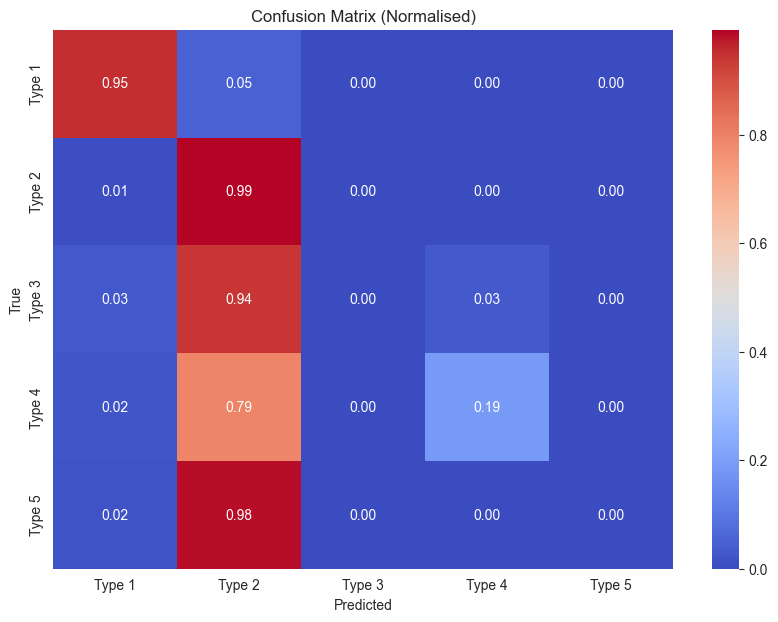

In [14]:
evaluate_model(model_path, X_test, y_test)  # ewaluacja modelu